# Download Data from Kaggle API

In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
print("Please upload your kaggle.json file:")
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.17GB/s]


In [ ]:
# Unzip the downloaded data
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


## Import required Packages

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, dataloader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducability
torch.manual_seed(42)

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Data

In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Get the shape of full dataset
df.shape

(60000, 785)

# Visualize Data

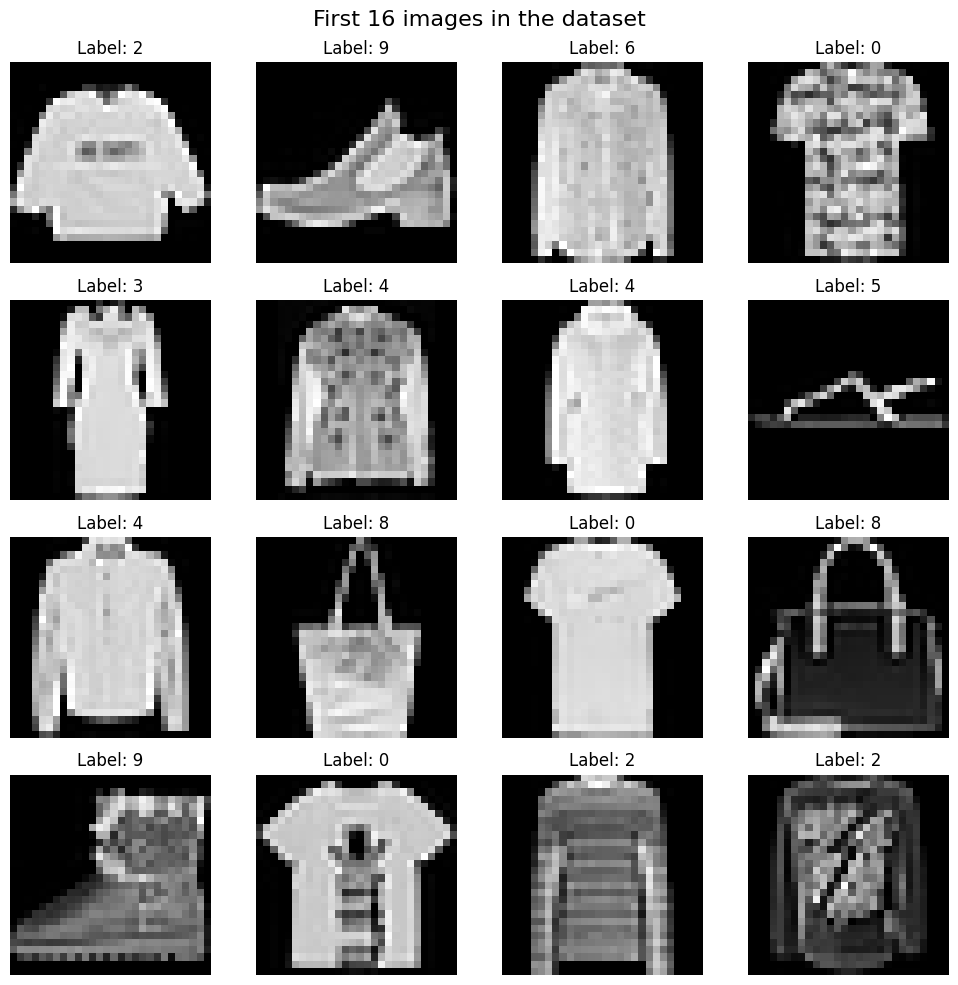

In [ ]:
# Create a 4x4 grid of image
fig, axes = plt.subplots(4, 4, figsize = (10, 10))
fig.suptitle("First 16 images in the dataset", fontsize = 16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28) # Reshape image to 28 x 28
  ax.imshow(img, cmap = 'gray') # Display image as gray-scale
  ax.axis('off') # Turn off axes for a clean look
  ax.set_title(f"Label: {df.iloc[i, 0]}") # Show the label

plt.tight_layout()
plt.show()

# Split Data into Train Test set

In [ ]:
# Split labels and features
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Defining Dataset and Dataloader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, features, labels):

    # Convert labels and features into PyTorch tensors
    self.features = torch.tensor(features, dtype = torch.float32).reshape(-1, 1, 28, 28) # Convert 1d features into 2d image
    self.labels = torch.tensor(labels, dtype = torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [ ]:
# Create train and test dataset instances of above defined class
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

In [ ]:
print(train_dataset[0])

(tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,  58., 136.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,
            7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,  55.,  80.,
          108., 151., 255.,   0.,   0.,   0.],
    

# Train and test dataloader

In [ ]:
train_loader = dataloader.DataLoader(train_dataset, batch_size = 256, shuffle = True)
test_loader = dataloader.DataLoader(test_dataset, batch_size = 256, shuffle = False)

# Define CNN Model

In [ ]:
# Create Train and Test dataloader onjects
class MyCNN(nn.Module):

  def __init__(self, input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size = 3, padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 2nd layer
        nn.Conv2d(32, 64, kernel_size = 3, padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(64, 10)
    )


  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [ ]:
# Define Learning Rate and Epochs
learning_rate = 0.01
epochs = 100

In [ ]:
# Create Model instance from Class
model = MyCNN(1)

model.to(device) # Shift the model according to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-4)

# Define Training Loop

In [ ]:
# Training Loop

for epoch in range(epochs):
  total_epoch_loss = 0 # variable to hold total epoch loss

  for batch_features, batch_labels  in train_loader: #
    # Move data according to device type (CPU or GPU)
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # Forward Pass
    outputs = model(batch_features)

    # Calculate loss
    loss = criterion(outputs, batch_labels)

    # Back Pass
    # Zero out previous grad values
    optimizer.zero_grad()
    loss.backward()

    # Update grads
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")
#

Epoch: 1, Loss: 1.2376
Epoch: 2, Loss: 0.7179
Epoch: 3, Loss: 0.5950
Epoch: 4, Loss: 0.5285
Epoch: 5, Loss: 0.4811
Epoch: 6, Loss: 0.4447
Epoch: 7, Loss: 0.4156
Epoch: 8, Loss: 0.3943
Epoch: 9, Loss: 0.3760
Epoch: 10, Loss: 0.3616
Epoch: 11, Loss: 0.3442
Epoch: 12, Loss: 0.3323
Epoch: 13, Loss: 0.3201
Epoch: 14, Loss: 0.3118
Epoch: 15, Loss: 0.3026
Epoch: 16, Loss: 0.2933
Epoch: 17, Loss: 0.2837
Epoch: 18, Loss: 0.2766
Epoch: 19, Loss: 0.2708
Epoch: 20, Loss: 0.2625
Epoch: 21, Loss: 0.2585
Epoch: 22, Loss: 0.2499
Epoch: 23, Loss: 0.2441
Epoch: 24, Loss: 0.2393
Epoch: 25, Loss: 0.2315
Epoch: 26, Loss: 0.2270
Epoch: 27, Loss: 0.2199
Epoch: 28, Loss: 0.2148
Epoch: 29, Loss: 0.2113
Epoch: 30, Loss: 0.2080
Epoch: 31, Loss: 0.2042
Epoch: 32, Loss: 0.1948
Epoch: 33, Loss: 0.1947
Epoch: 34, Loss: 0.1876
Epoch: 35, Loss: 0.1871
Epoch: 36, Loss: 0.1799
Epoch: 37, Loss: 0.1763
Epoch: 38, Loss: 0.1684
Epoch: 39, Loss: 0.1675
Epoch: 40, Loss: 0.1629
Epoch: 41, Loss: 0.1619
Epoch: 42, Loss: 0.1602
E

# Model Evaluation

In [ ]:
# Evaluation on Test Data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    # Move data to GPU
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # Get inference from the model
    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1) # Get the maximum probability

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

  print(f"Model Accuracy: {correct/total*100:.2f} %")

Model Accuracy: 90.57 %


In [ ]:
# Evaluation on Train Data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    # Move data to GPU
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # Get inference from the model
    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1) # Get the maximum probability

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

  print(f"Model Accuracy: {correct/total*100:.2f} %")

Model Accuracy: 98.53 %
